In [7]:
# Importing neccessary packages
import numpy as np
import tensorflow as tf
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
os.listdir('.')

['.config',
 'validation',
 'food11.zip',
 'evaluation',
 'drive',
 'training',
 'kaggle.json',
 'sample_data']

In [0]:
NUM_CLASSES = 11

In [0]:
# Data augmentation for regularization and adding some extra training samples

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    rescale=1.0/255.0,
    horizontal_flip=True, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=30
)

In [0]:
TARGET_DIM = 224
BATCH_SIZE = 32

In [25]:
train_generator = datagen.flow_from_directory(
    directory='./training/', 
    target_size=(TARGET_DIM, TARGET_DIM),
    batch_size=BATCH_SIZE,
)

validation_generator = datagen.flow_from_directory(
    directory='./validation/',
    target_size=(TARGET_DIM, TARGET_DIM),
    batch_size=BATCH_SIZE
)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [0]:
# Lets try the Xception architecture

base_model = tf.keras.applications.xception.Xception(
    include_top=False, 
    weights='imagenet', 
    input_shape=(TARGET_DIM, TARGET_DIM, 3)
)

In [0]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [0]:
print('Layers in Xception: ' + str(len(base_model.layers)))

Layers in Xception: 132


In [0]:
preds = base_model.output
preds = tf.keras.layers.GlobalAveragePooling2D()(preds)
preds = tf.keras.layers.Dense(512, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.BatchNormalization()(preds)
preds = tf.keras.layers.Dropout(0.5)(preds)
preds = tf.keras.layers.Dense(256, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.BatchNormalization()(preds)
preds = tf.keras.layers.Dropout(0.3)(preds)
preds = tf.keras.layers.Dense(128, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.Dense(11, activation=tf.nn.softmax)(preds)

In [0]:
model = tf.keras.models.Model(base_model.input, preds)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
model.layers[-15].name

'block14_sepconv1'

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [0]:
# Create directory in drive for storing model
!mkdir drive/My\ Drive/food_11_weights

In [0]:
# Lets define checkpoint for model saving
filepath="./drive/My Drive/food_11_weights/xception-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
# Freeze mobilenet layers and train only newly added layers

for layers in model.layers[:-15]:
    layers.trainable = False

for layers in model.layers[-15:]:
    layers.trainable = True

In [0]:
# Lets stop training when model acheives desired accuracy

class ModelCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs):
        # Check if validation accuracy is above 90% then stop training
        if logs['acc'] >= 0.95:
            print('Model reached its target')
            self.model.stop_training = True
            
model_callback = ModelCallback()

In [0]:
#Let's train the model 5 epochs as it will take a lot of time

model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, model_callback],
    epochs=50
)

Epoch 1/50
308/308 [==============================] - ETA: 0s - loss: 2.4331 - acc: 0.1563
Epoch 00001: val_acc improved from -inf to 0.14574, saving model to ./drive/My Drive/food_11_weights/xception-01-0.15.hdf5
308/308 [==============================] - 265s 859ms/step - loss: 2.4331 - acc: 0.1563 - val_loss: 2.3124 - val_acc: 0.1457
Epoch 2/50
308/308 [==============================] - ETA: 0s - loss: 2.2461 - acc: 0.1822
Epoch 00002: val_acc did not improve from 0.14574
308/308 [==============================] - 260s 845ms/step - loss: 2.2461 - acc: 0.1822 - val_loss: 2.7456 - val_acc: 0.1048
Epoch 3/50
308/308 [==============================] - ETA: 0s - loss: 2.2619 - acc: 0.1751
Epoch 00003: val_acc improved from 0.14574 to 0.16443, saving model to ./drive/My Drive/food_11_weights/xception-03-0.16.hdf5
308/308 [==============================] - 262s 850ms/step - loss: 2.2619 - acc: 0.1751 - val_loss: 2.6175 - val_acc: 0.1644
Epoch 4/50
308/308 [==============================] -

In [0]:
model.history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [0]:
history = model.history.history

Text(0, 0.5, 'Accuracy')

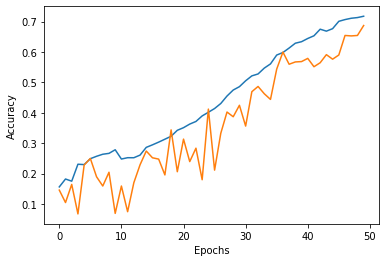

In [0]:
plt.plot(range(50), history['acc'])
plt.plot(range(50), history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Observations:

Model validation accuracy is fluctuating because of high learning rate.

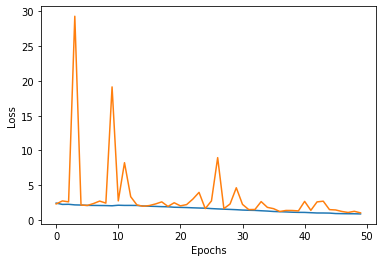

In [0]:
plt.plot(range(50), history['loss'])
plt.plot(range(50), history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [0]:
# Lets train the model for further epochs
model = tf.keras.models.load_model("./drive/My Drive/food_11_weights/xception-50-0.69.hdf5")

In [0]:
# Compile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc']
)
# Lets define checkpoint for model saving
filepath="./drive/My Drive/food_11_weights/xception-further-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [33]:
%%time
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, model_callback],
    epochs=30
)

Epoch 1/30
308/308 [==============================] - ETA: 0s - loss: 0.7034 - acc: 0.7715
Epoch 00001: val_acc improved from -inf to 0.76373, saving model to ./drive/My Drive/food_11_weights/xception-further-01-0.76.hdf5
308/308 [==============================] - 456s 1s/step - loss: 0.7034 - acc: 0.7715 - val_loss: 0.7589 - val_acc: 0.7637
Epoch 2/30
308/308 [==============================] - ETA: 0s - loss: 0.6735 - acc: 0.7823
Epoch 00002: val_acc improved from 0.76373 to 0.76840, saving model to ./drive/My Drive/food_11_weights/xception-further-02-0.77.hdf5
308/308 [==============================] - 452s 1s/step - loss: 0.6735 - acc: 0.7823 - val_loss: 0.7550 - val_acc: 0.7684
Epoch 3/30
308/308 [==============================] - ETA: 0s - loss: 0.6482 - acc: 0.7942
Epoch 00003: val_acc did not improve from 0.76840
308/308 [==============================] - 457s 1s/step - loss: 0.6482 - acc: 0.7942 - val_loss: 0.7463 - val_acc: 0.7629
Epoch 4/30
308/308 [==========================

In [0]:
history = model.history.history

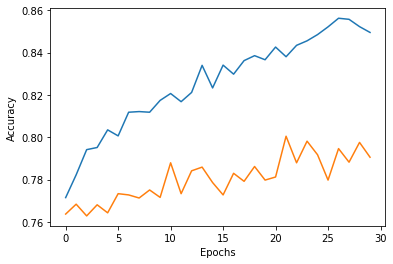

In [35]:
plt.plot(range(30), history['acc'])
plt.plot(range(30), history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Observations:

It appears that model accuracy improved but its far from training accuracy. So model is starting to overfit.

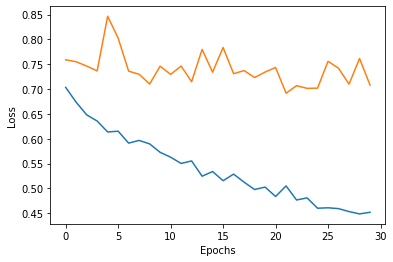

In [37]:
plt.plot(range(30), history['loss'])
plt.plot(range(30), history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Observations:

It appears that model validation loss keeps on fluctuating but training loss decreased so model is started to overfit.